In [1]:
import pandas as pd
from matplotlib.pyplot import figure
import itertools
from tqdm import tqdm
from collections import defaultdict
import numpy as np
from random import shuffle
from surprise.model_selection import KFold


In [2]:
def get_data(filename=  'data_pos_neg_neu.txt'):
    '''
    read the list of dict for postive,negative,neutral feedback
    '''
    data = []
    with open(filename) as f:
        for i, line in enumerate(f):
            try:
                d = eval(line)
            except:
                print("*****Error*****")
                print(i,line)
                print("*********END of ERROR *******")
                break
            else:
                data.append(d)
    return data

In [3]:
data = get_data()

In [4]:
result = []
for j in range(len(data)):    
    for i in data[j]['pos']:
        result.append(('user'+str(j),i,1))
    for i in data[j]['neg']:
        result.append(('user'+str(j),i,-1))
    for i in data[j]['neu']:
        result.append(('user'+str(j),i,0))

In [5]:
shuffle(result) # 打乱数据

In [6]:
# 用dict表示
c = []
for line in tqdm(result):
    d = dict(zip(['user','product','rating'],[]))
    d['user'] = line[0]
    d['product'] = line[1]
    d['rating'] = line[2]
    c.append(d)

100%|██████████| 1859626/1859626 [00:02<00:00, 852449.47it/s]


In [7]:
# 抄的老师的workbook4
productsPerUser = defaultdict(set)
itemsPerUser = defaultdict(set)
usersPerItem = defaultdict(set)
ratingDict = {}

In [8]:
# 把一位用户对应的所有产品整理出来
for d in c:
    user,item,rating = d['user'],d['product'],d['rating']
    productsPerUser[user].add((item,rating))
    itemsPerUser[user].add(item)
    usersPerItem[item].add(user)
    ratingDict[(user,item)] = rating

In [9]:
# 计算user average 和 item average
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

In [10]:
# 查看一共有多少pos，neg，neu
pos = 0
neg = 0
neu = 0
for i in tqdm([i for i in productsPerUser]):
    for j in productsPerUser[i]:
        if j[1] == 1:
            pos += 1
        elif j[1] == -1:
            neg += 1
        else:
            neu += 1

100%|██████████| 83384/83384 [00:00<00:00, 159346.94it/s]


In [11]:
pos,neg,neu

(859773, 572505, 427348)

In [12]:
# similarity functions
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

def CosineSet(s1, s2):
    # Not a proper implementation, operates on sets so correct for interactions only
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

def Cosine(i1, i2):
    # Between two items
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += ratingDict[(u,i1)]*ratingDict[(u,i2)]
    for u in usersPerItem[i1]:
        denom1 += ratingDict[(u,i1)]**2
    for u in usersPerItem[i2]:
        denom2 += ratingDict[(u,i2)]**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom


In [13]:
# define the similarity function
def mostSimilar(i, N):
    similarities = []
    items = itemsPerUser[i]
    for i2 in itemsPerUser:
        if i2 == i: continue
        sim = Jaccard(items, itemsPerUser[i2])
        #sim = Pearson(i, i2) # Could use alternate similarity metrics straightforwardly
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    return similarities[:N]

In [14]:
# find top 10 similar users with user10
mostSimilar('user2',10)

[(0.6190476190476191, 'user16778'),
 (0.5909090909090909, 'user5807'),
 (0.5652173913043478, 'user22033'),
 (0.5517241379310345, 'user82333'),
 (0.5454545454545454, 'user19530'),
 (0.5357142857142857, 'user76767'),
 (0.5357142857142857, 'user70477'),
 (0.5217391304347826, 'user29118'),
 (0.52, 'user80000'),
 (0.52, 'user38407')]

In [15]:
# 所有的rating mean
ratingMean = sum([d[2] for d in result])/len(result)

In [16]:

ratingMean

0.15447622263831545

In [17]:
# 老师的代码
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

In [18]:
# 老师的代码
for d in c:
    user,item = d['user'], d['product']
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)

In [19]:
# 老师的代码
def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['product']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return ratingMean

In [20]:
# 预测用户1对python 的评分
predictRating('user1','Python')

-0.6175758828930583

In [21]:
# 找出所有的产品
all_products = np.array([i[1] for i in result])

In [22]:
# 找出所有产品的unique，去掉重复的
all_products = np.unique(all_products)

In [23]:
# 预测用户1对所有产品的评分
prediction = []
for i in all_products:
    a = predictRating('user1',i)
    prediction.append([i,a])

In [24]:
# 排列一下
prediction.sort(key=lambda x: x[1],reverse=True)

In [25]:
# 写成一个function
def predict_all(user):
    #user = str(user)
    prediction = []
    for i in all_products:
        a = predictRating(user,i)
        prediction.append([i,a])
        prediction.sort(key=lambda x: x[1],reverse=True)
    return prediction

In [29]:
all_users = np.unique(np.array([i[0] for i in result]))

## SVM with surprise

In [29]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise import accuracy

In [30]:
# split the data into 0.9 and 0.1
train = int(len(productsPerUser)*0.84)
#test = int(len(productsPerUser)*0.84)

In [31]:
# split to train and valid
all_user = [i for i in productsPerUser]
train_user = all_user[:train]
#test_user = all_user[train:test]
valid_user = all_user[train:]

In [32]:
# get the train data
train_data = []
for i in train_user:
    for j in productsPerUser[i]:
        train_data.append((i,j[0],j[1]))

In [33]:
# get the valid data
valid_data = []
for i in valid_user:
    for j in productsPerUser[i]:
        valid_data.append((i,j[0],j[1]))

In [34]:
len(train_data),len(valid_data)

(1676095, 183531)

# Not all training data user for training (edited)


In [45]:
# full dataframe
full_df = pd.DataFrame(result,columns = ['userID', 'itemID', 'rating'])

In [36]:
# scale, from -1 to 1
reader = Reader(rating_scale=(-1,1))

In [51]:
# transform the data so that surprise package can handle the data
full_data = Dataset.load_from_df(full_df[['userID', 'itemID', 'rating']], reader)

In [52]:
# split the train data to train and test
trainset, testset = train_test_split(full_data, test_size=.16,random_state=88)

In [53]:
# define the svd function 
algo_svd = SVD()

# Train the algorithm on the trainset
algo_svd.fit(trainset)


In [57]:
#predict ratings for the testset
predictions_svd = algo_svd.test(testset)
# Then compute RMSE
accuracy.rmse(predictions_svd)

RMSE: 0.7268


0.726806252620528

In [58]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [59]:
#predictions_svd = algo_svd.test(valid_data)

In [62]:
precisions, recalls = precision_recall_at_k(predictions_svd, k=5, threshold=0)

print('average precision@5 is: ', sum(prec for prec in precisions.values()) / len(precisions))
print('average recall@5 is: ',sum(rec for rec in recalls.values()) / len(recalls))
print('average f1 score @5 is ', sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions))

average precision@5 is:  0.8059923549692676
average recall@5 is:  0.4190675363640556
average f1 score @5 is  0.39125105556502565


## BaselineOnly

In [63]:
from surprise import BaselineOnly # algorithm that is used to establish minimum expected performance on a dataset

In [64]:
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }

In [65]:
algo_base = BaselineOnly(bsl_options=bsl_options)

In [66]:
algo_base.fit(trainset)
predictions_base = algo_base.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_base)

Estimating biases using als...
RMSE: 0.7492


0.7491632526967469

In [67]:
predictions_base = algo_base.test(testset)

In [68]:
precisions, recalls = precision_recall_at_k(predictions_base, k=5, threshold=0)

print('average precision@5 is: ', sum(prec for prec in precisions.values()) / len(precisions))
print('average recall@5 is: ',sum(rec for rec in recalls.values()) / len(recalls))
print('average f1 score @5 is ', sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions))

average precision@5 is:  0.6743817225069035
average recall@5 is:  0.6850647036044005
average f1 score @5 is  0.5956236436554049


### using sgd

In [69]:
bsl_options = {'method': 'sgd',
               'learning_rate': .00005,
               }
algo_base2 = BaselineOnly(bsl_options=bsl_options)

In [70]:
algo_base2.fit(trainset)
predictions_base2 = algo_base2.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_base2)

Estimating biases using sgd...
RMSE: 0.8318


0.831791842890089

In [71]:
predictions_base2 = algo_base2.test(testset)
precisions, recalls = precision_recall_at_k(predictions_base2, k=5, threshold=0)

print('average precision@5 is: ', sum(prec for prec in precisions.values()) / len(precisions))
print('average recall@5 is: ',sum(rec for rec in recalls.values()) / len(recalls))
print('average f1 score @5 is ', sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions))

average precision@5 is:  0.70792193522355
average recall@5 is:  0.7510151185409956
average f1 score @5 is  0.6269373318534507


## SlopeOne

In [72]:
from surprise import SlopeOne

In [73]:
algo_slope = SlopeOne()

In [74]:
algo_slope.fit(trainset)
predictions_slope = algo_slope.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_slope)

/tmp/ipykernel_809/1804627863.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo_slope.fit(trainset)


RMSE: 0.7383


0.7383110992621169

In [75]:
predictions_slope = algo_slope.test(testset)
precisions, recalls = precision_recall_at_k(predictions_slope, k=5, threshold=0)

print('average precision@5 is: ', sum(prec for prec in precisions.values()) / len(precisions))
print('average recall@5 is: ',sum(rec for rec in recalls.values()) / len(recalls))
print('average f1 score @5 is ', sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions))

average precision@5 is:  0.6512998635110863
average recall@5 is:  0.6594180846800406
average f1 score @5 is  0.5765770018549038


## Coslustering

In [76]:
from surprise import CoClustering

In [77]:
algo_co = CoClustering()

In [78]:
algo_co.fit(trainset)
predictions_co = algo_co.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_co)

/tmp/ipykernel_809/2540439433.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo_co.fit(trainset)


RMSE: 0.7558


0.755835196977537

In [79]:
predictions_co = algo_co.test(valid_data)
precisions, recalls = precision_recall_at_k(predictions_co, k=5, threshold=0)

print('average precision@5 is: ', sum(prec for prec in precisions.values()) / len(precisions))
print('average recall@5 is: ',sum(rec for rec in recalls.values()) / len(recalls))
print('average f1 score @5 is ', sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions))

average precision@5 is:  0.7900327287263317
average recall@5 is:  0.4093592076798645
average f1 score @5 is  0.3826315906044123


## weighted

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

In [81]:
def precision_recall_at_k_weighted(pred1,pred2,weight1, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    pred = [(i.uid,i.r_ui,weight1*i.est+(1-weight1)*j.est) for i,j in zip(pred1,pred2)]
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for i in pred:
        uid,true_r,est = i[0],i[1],i[2]
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
    a = sum(prec for prec in precisions.values()) / len(precisions)
    b = sum(rec for rec in recalls.values()) / len(recalls)
    c = sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions)
    print('average precision@5 is: ', a)
    print('average recall@5 is: ',b)
    print('average f1 score @5 is ', c)
    return a, b, c

In [82]:
# combine baseline model and coclustering model, with baseline 0.8 and coclustering weighted 0.2
precision_recall_at_k_weighted(predictions_base,predictions_co,0.8, k=10, threshold=0)

average precision@5 is:  0.6583743908980089
average recall@5 is:  0.6973151711444452
average f1 score @5 is  0.6173203543767168


(0.6583743908980089, 0.6973151711444452, 0.6173203543767168)

In [83]:
# select model from:
#predictions_base,predictions_base2,predictions_slope,predictions_co,predictions_svd
def two_weighted_model(model1,model2):
    weight = []
    for i in [i/10 for i in range(1,10)]:
        print('when weight is: ',i)
        d,e,f = precision_recall_at_k_weighted(model1,model2,i, k=10, threshold=0)
        weight.append([i,d,e,f])
    newdata = []
    for i in weight:
        newdata.append([i[0],i[1],'precision'])
    for i in weight:
        newdata.append([i[0],i[2],'recall'])
    for i in weight:
        newdata.append([i[0],i[3],'f1'])        
    df = pd.DataFrame(newdata,columns=['weight','value','type'])
    sns.lineplot(data=df,x='weight',y='value',hue='type')
    plt.show()
        

when weight is:  0.1
average precision@5 is:  0.6327570614920258
average recall@5 is:  0.6362722509187523
average f1 score @5 is  0.5419572613253337
when weight is:  0.2
average precision@5 is:  0.6381686030655087
average recall@5 is:  0.6473267143056887
average f1 score @5 is  0.5511481346685915
when weight is:  0.3
average precision@5 is:  0.6447547284950614
average recall@5 is:  0.6604242782140338
average f1 score @5 is  0.562333095904206
when weight is:  0.4
average precision@5 is:  0.6521795794014409
average recall@5 is:  0.6751274333580163
average f1 score @5 is  0.5749144276409776
when weight is:  0.5
average precision@5 is:  0.6602098049509962
average recall@5 is:  0.6915132240103431
average f1 score @5 is  0.5889384358934109
when weight is:  0.6
average precision@5 is:  0.6686739474808588
average recall@5 is:  0.7102623135122247
average f1 score @5 is  0.6055006145030137
when weight is:  0.7
average precision@5 is:  0.6774695221731253
average recall@5 is:  0.7280892853662584
a

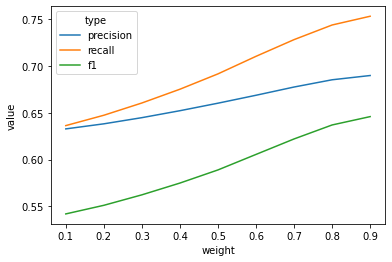

In [85]:
# example
two_weighted_model(predictions_base2,predictions_svd)